In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry.polygon import LinearRing
from scipy.misc import imread
import json

import helpers

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

In [2]:
# c_data = pd.read_pickle("candidate_data.p")
# c_data.head()

In [8]:
with open("infrastructure_store.json", "r") as json_data:
    d = json.load(json_data)
    
    stickerLocations = pd.DataFrame.from_dict(d["stickerLocations"])
    baseStationData  = pd.DataFrame.from_dict(d['baseStationData'])
    seats            =  pd.DataFrame.from_dict(d['seats'])
    outer   = d['outer']
    inner   = d['inner']
    isovist = d['isovist']
OG = nx.read_gpickle("graph.p")

In [10]:
def draw_infrastructure(title="Sticker and Base Station Locations", draw_graph=False, draw_img=False, 
                        draw_boundaries=False, draw_axes=False, draw_stickers=False, draw_basestations=False, draw_seat_names=False,
                        pad_x_pc=0.05, pad_y_pc=0.01,
                       sticker_label_size=7, name_label_size=5, base_label_size=10):
    """Draw the fixed infrastructure of the sensicorn project."""
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    
    def plot_line(ob, colour="r"):
        x, y = ob.xy
        plt.plot(x, y, color=colour, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
    
    fig, ax = plt.subplots()

    plt.title(title)
    
    legend_items = []
    
    # set axis limits with a bit of padding
    x = [pair[0] for pair in outer[0]] # get boundary limits
    y = [pair[1] for pair in outer[0]]
    pad_y = (max(y) - min(y)) * pad_y_pc
    pad_x = (max(x) - min(x)) * pad_x_pc
    axes = plt.gca()
    axes.set_ylim([min(y) - pad_y, max(y) + pad_y])
    axes.set_xlim([min(x) - pad_x, max(x) + pad_x])
    
    if draw_img:
        # put the image on the graph as an underlay
        img = imread("map.png")
        ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
        #                                [left, right, bottom, top  ]

    if draw_boundaries:
        for boundary_set, colour in [(inner, "r"),(isovist, "g"),(outer, "b")]:
            for e in boundary_set:
                ring = LinearRing(e)
                plot_line(ring, colour)
        legend_inner = mlines.Line2D([], [], color='r', label='Inner Boundary')
        legend_isovist = mlines.Line2D([], [], color='g', label='Isovist Boundary')
        legend_outer = mlines.Line2D([], [], color='b', label='Outer Boundary')
        legend_items.extend([legend_inner, legend_isovist, legend_outer])

    if draw_graph:
        pos = {n[0]: (n[1]["x"], n[1]["y"]) for n in OG.nodes(data=True)}
        nx.draw(OG, alpha=0.3, s=1, pos=pos, node_shape=".", node_size=10)  # don't draw the graph

    if draw_basestations:
        # put the baseStations on the map
        for index, row in baseStationData.iterrows():
            ax.text(row.x, row.y, row.agentName, fontsize=base_label_size)
        base_stations = ax.scatter(baseStationData.x, baseStationData.y, marker='+', label='base stations')
        legend_items.append(base_stations)

    if not draw_axes:
        # Hide the axis numbers because they don't tell us much
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if draw_stickers:
        # the sticker labels
        for _, row in stickerLocations.iterrows():
            ax.text(row.x, row.y, "{0:03d}".format(int(row.stickerID)), fontsize=sticker_label_size)

        # sticker dots
        stickers = ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y", label='stickers')
        legend_items.append(stickers)
    
    if draw_seat_names:
        for _, row in seats.iterrows():
            ax.text(row.x, row.y, row["name"], fontsize=name_label_size, rotation=10) # .name must be a reserved word?

        # sticker dots
        seat_pos = ax.scatter(seats.x, seats.y, s=1, c="y", label='seats')
        legend_items.append(seat_pos)
        
    
    if len(legend_items) > 0:
        # red_patch = mpatches.Patch(color='red', label='The red data') # patch example
        plt.legend(handles=legend_items, loc='upper left')

    plt.show()

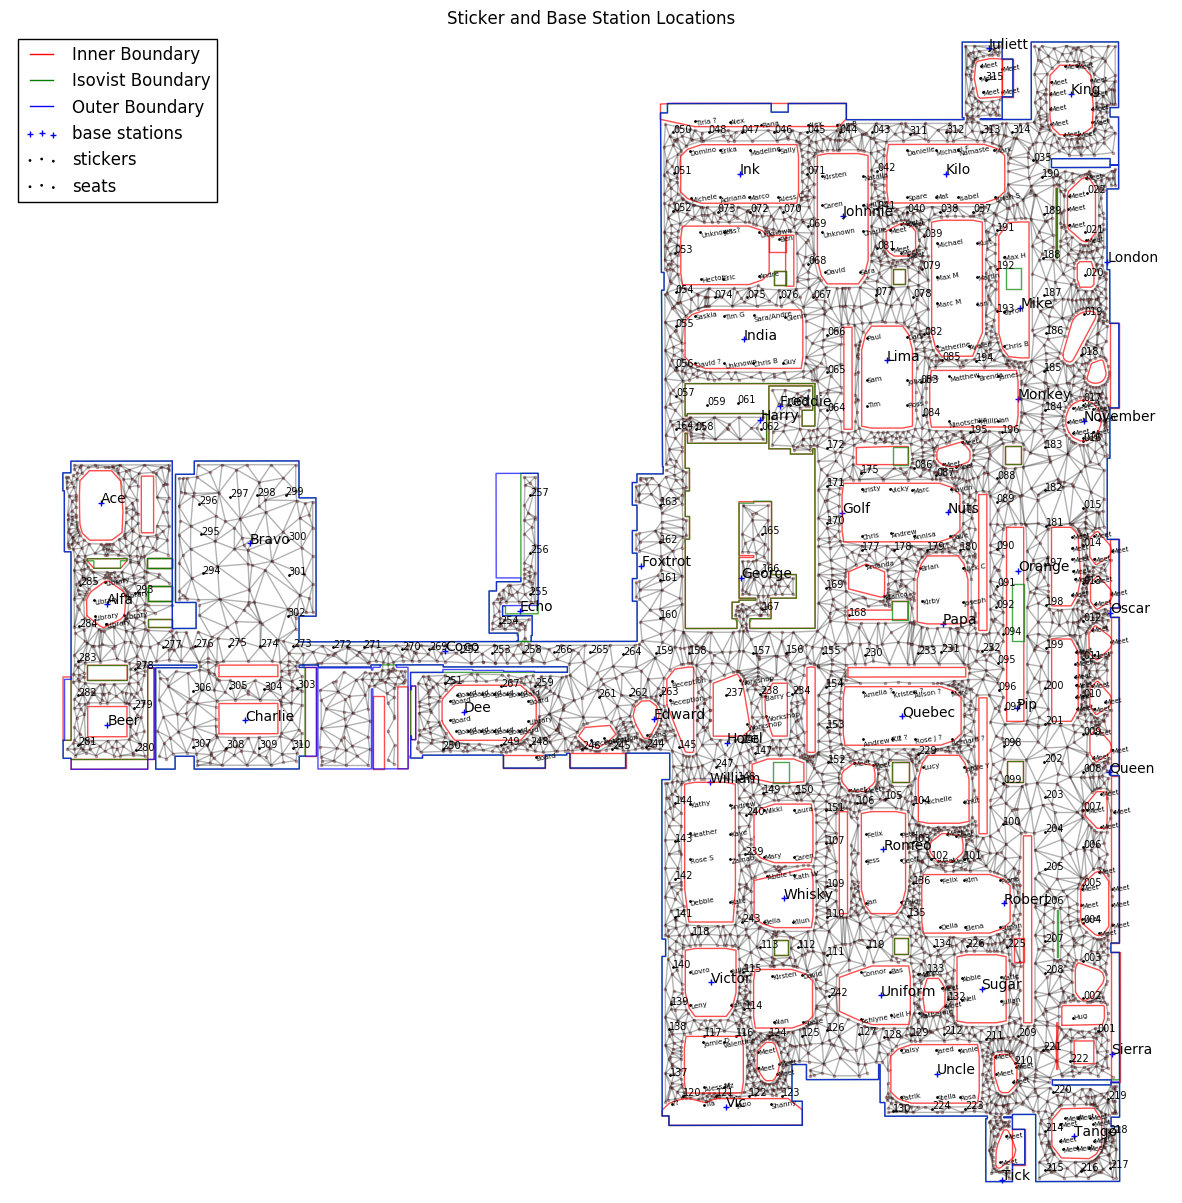

In [11]:
draw_infrastructure(draw_boundaries=True, 
                    draw_stickers=True, 
                    draw_basestations=True, 
                    draw_seat_names=True,
                    draw_graph=True)